<table>
    <tr style="background-color:white;">
        <td width="60%">
            <div style="height: 25px;"></div>
            <div align="left" style="color: #4b324e; font-size: 40px; font-weight: bold;">Taller de Qiskit</div>
        </td>
        <td>
            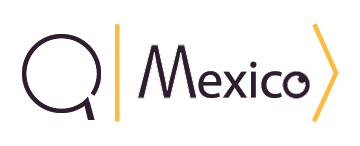
        </td>
    </tr>
</table>

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $

<div align="center" style="color: #EE2A6F; font-size: 30px; font-weight: bold;">Transpilador</div>

<div align="right" style="font-size: 15px; font-weight: normal;">Preparado por Diego Aguilar Muñoz</div>

<a href="https://opensource.org/licenses/Apache-2.0"></a>

# Contenido

1. [Introducción](#intro)
2. [Pases](#secc1)
3. [Mapa de acoplamiento](#secc2)
4. [Administradores de pases](#secc3)
   1. [Barreras](#secc3.1)
5. [Referencias](#secc4)

<a id="intro"></a>
# Introducción

Uno de los componentes más importantes de Qiskit Terra es el transpilador, el cual está diseñado para hacer transformaciones en el circuito que hayamos diseñado para mejorar su rendimiento, ya sea usando equivalencias que reduzcan el tiempo de ejecución en el simulador, o para reducir el ruido provocado por una computadora cuántica dependiendo de su arquitectura, esto es conocido como pase del transpilador. Es importante notar que estos pases pueden estar encadenados, es decir se puede formar un conjunto de transformaciones consecutivas en nuestro circuito, y el orden en el que se realizan va a afectar el resultado final. La herramienta que designa el orden de estas transformaciones es conocido como administrador de pases. 

In [1]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager, passes, CouplingMap, Layout
from qiskit.transpiler.passes import Unroller, BasicSwap, LookaheadSwap, StochasticSwap
from qiskit.test.mock import FakeTokyo, FakeArmonk
import math

<a id="secc1"></a>
# Pases

Existen diferentes tipos de pases dependiendo de la acción que se busca ejecutar sobre el circuito, ya sea para el diseño del mapa de acoplamiento (hablaremos de ellos más adelante), modificar el orden de nuestros qubits para acomodarse a cierta arquitectura de una computadora cuántica real, optimizar el rendimiento de nuestro circuito, entre otros. Si se quiere conocer toda la lista de pases predeterminados se puede usar la siguiente celda de código. Para obtener información específica para cada uno de ellos se puede consultar el siguiente <a href="https://qiskit.org/documentation/apidoc/transpiler_passes.html">enlace</a>.

In [2]:
[pass_ for pass_ in dir(passes) if pass_[0].isupper()]

['ALAPSchedule',
 'ASAPSchedule',
 'AlignMeasures',
 'ApplyLayout',
 'BIPMapping',
 'BarrierBeforeFinalMeasurements',
 'BasicSwap',
 'BasisTranslator',
 'CSPLayout',
 'CXCancellation',
 'CXDirection',
 'CheckCXDirection',
 'CheckGateDirection',
 'CheckMap',
 'Collect2qBlocks',
 'CommutationAnalysis',
 'CommutativeCancellation',
 'ConsolidateBlocks',
 'CountOps',
 'CountOpsLongestPath',
 'CrosstalkAdaptiveSchedule',
 'DAGFixedPoint',
 'DAGLongestPath',
 'Decompose',
 'DenseLayout',
 'Depth',
 'DynamicalDecoupling',
 'EnlargeWithAncilla',
 'Error',
 'FixedPoint',
 'FullAncillaAllocation',
 'GateDirection',
 'HoareOptimizer',
 'Layout2qDistance',
 'LayoutTransformation',
 'LookaheadSwap',
 'MergeAdjacentBarriers',
 'NoiseAdaptiveLayout',
 'NumTensorFactors',
 'Optimize1qGates',
 'Optimize1qGatesDecomposition',
 'OptimizeSwapBeforeMeasure',
 'RZXCalibrationBuilder',
 'RZXCalibrationBuilderNoEcho',
 'RemoveBarriers',
 'RemoveDiagonalGatesBeforeMeasure',
 'RemoveFinalMeasurements',
 'RemoveR

Uno de los pases más sencillos es `Unroller()`, descomponer las compuertas aplicadas en nuestro circuito a una serie de compuertas que nosotros designemos como argumento de nuestra clase. Por ejemplo, podemos descomponer la compuerta Toffoli en una combinación de compuertas unitarias y compuertas *CNOT* como se muestra en el siguiente ejemplo:

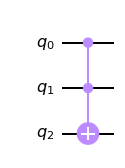

In [3]:
# Definimos un circuito de 3 qubits
qc = QuantumCircuit(3)
#Aplicamos la compuerta Toffoli
qc.ccx(0,1,2)
#Observemos el circuito antes de la tranformación
qc.draw(output='mpl')

Lo primero que hacemos es definir nuestro pase, en este caso `Unroller()` y colocamos como argumento las compuertas de rotación unitarias y la *CNOT* que son las compuertas en las que queremos descomponer nuestra compuerta Toffoli. 

El siguiente paso será definir nuestro administrador de pases, esto se hace con la clase `PassManager()` que puede tomar 2 argumentos, el primero puede ser un arreglo con la serie de pases que va a ejecutar y el segundo es un entero con el número de iteraciones que se quiere realizar, si no se coloca ningún argumento, solo se realiza una iteración. Finalmente para ejecutar este administrador de pases sobre el circuito se utiliza el método `run()` que toma como argumento el circuito a transformar.

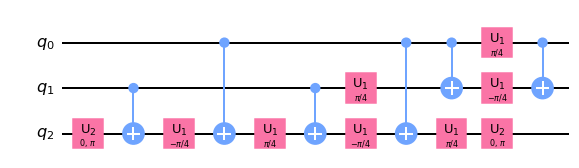

In [4]:
# Designamos Unroller como el pase a utilizar
pass_ = Unroller(['u1', 'u2', 'u3', 'cx'])

# Definimos nuestro administrador de pases con una iteración
pm = PassManager(pass_)

# Transformamos el circuito
circ = pm.run(qc)

# Dibujamos el circuito
circ.draw(output='mpl')

<a id="secc2"></a>
# Mapas de acoplamiento

Antes de seguir analizando los diferentes tipos de pases predeterminados en Qiskit Terra, debemos analizar uno de los conceptos importantes para entender el siguiente tipo de pase: Los mapas de acoplamiento. Los circuitos cuánticos que hasta ahora hemos trabajado son representaciones virtuales de qubits reales en computadoras cuánticas y necesitamos una forma de establecer una relación entre ellos.

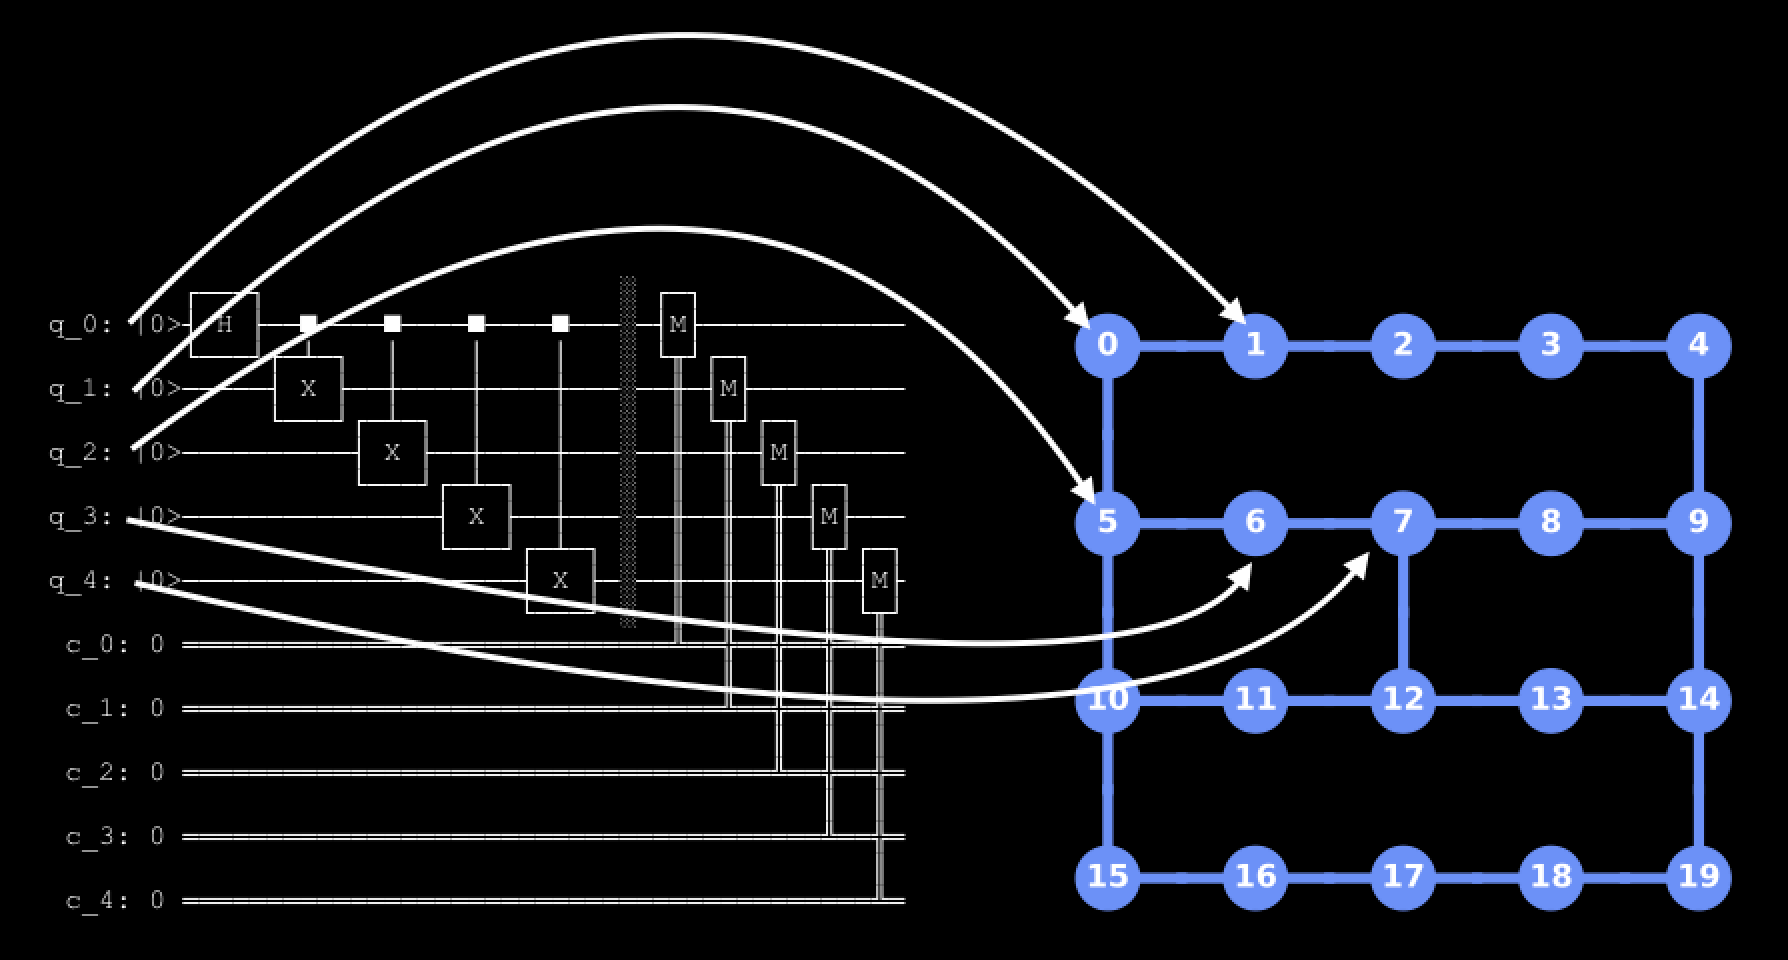

La imagen anterior representa la relación entre los qubits virtuales de nuestro circuito con los de una computadora física, en este caso una computadora de 19 qubits. En el lado derecho de la imagen se pueden observar las relaciones entre los qubits reales de nuestra computadora, es decir, las líneas que unen algunos de los qubits representan conexiones directas que reducen el ruido entre ellos cuando se utiliza una compuerta de 2 qubits a comparación de 2 qubits que no se encuentren acoplados. Esto es conocido como mapa de acoplamiento.

Por defecto, Qiskit desarrolla este mapa dependiendo de las propiedades del circuito físico que se busca trabajar. Las 2 estrategias de mapeo más sencillas son:

* **Diseño trivial**: Mapea los qubits virtuales en el mismo orden de los qubits físicos que en el dispositivo sin tomar en cuenta el acoplamiento.

* **Diseño de densidad**: Busca una subsección del circuito con el mismo número de qubits que tenga el mayor acoplamiento entre ellos.

Esto se puede decidir utilizando los pases `TrivialLayout` y `DenseLayout` respectivamente.

Una vez desarrollado el mapa de acoplamiento, existen una serie de pases que permiten utilizar compuertas *Swap* para cambiar el orden en los qubits y así obtener la mejor relación entre el circuito de qubits digitales y el mapa de acoplamiento de los qubits en una computadora real. Para esto existen 3 pases: `BasicSwap()`, `LookaheadSwap()` y `StochasticSwap()`, que toman como argumento el mapa de acoplamiento para y obtener la relación deseada. Podemos realizar el siguiente ejemplo para notar las diferencias:

Empezamos diseñando un circuito de 7 qubits con una serie de compuertas CNOT entre ellos

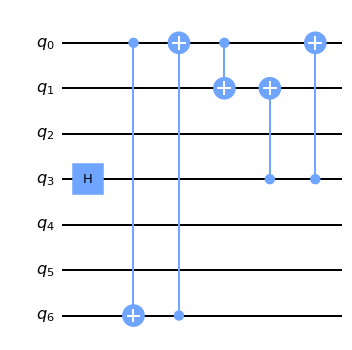

In [5]:
# Podemos empezar diseñando un circuito de 7 qubits con una serie de compuertas CNOT entre ellos
qc = QuantumCircuit(7)
qc.h(3)
qc.cx(0,6)
qc.cx(6,0)
qc.cx(0,1)
qc.cx(3,1)
qc.cx(3,0)

# Visualizamos el circuito virtual
qc.draw(output = 'mpl')

El siguiente paso es generar el mapa de acoplamiento , para esto se ocupa la clase `CouplingMap()`, la cual toma como argumento un arreglo compuesto por pares de números correspondientes a los qubits acoplados en nuestro sistema.

In [6]:
# Designamos las relaciones de acoplamiento entre nuestros qubits y creamos el mapa de acoplamiento
acoplamiento = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]
mapa = CouplingMap(couplinglist=acoplamiento)

Podemos notar de la lista `acoplamiento` que los qubits solo tienen acoplamiento entre sus qubits consecutivos (El qubit 1 está acoplado con el 0 y el 2, el 2 con el 1 y el 3, etc.), por lo tanto no existe un acoplamiento definido para alguno de los qubits sobre los que tenemos compuertas *CNOT* como es el caso de todas las compuertas excepto la CNOT entre el qubit 0 y el 1. Por lo tanto vamos a querer utilizar compuertas *Swap* para tener estas compuertas con qubits que se encuentren acoplados.

Podemos empezar usando `BasicSwap`, este es el paso más sencillo que analiza una por una las compuertas del sistema para utilizar compuertas *Swap* y tener interacciones entre qubits acoplados.

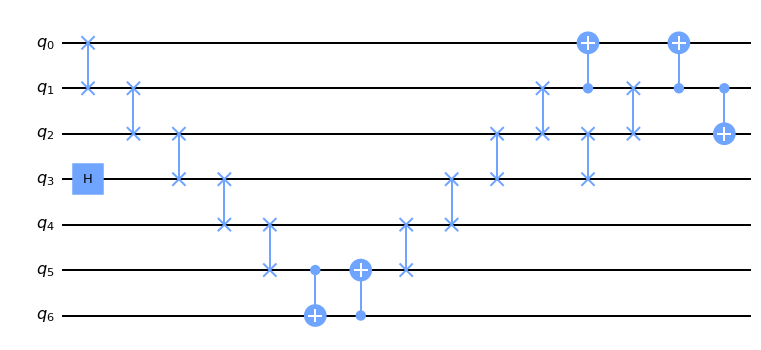

In [7]:
# Designamos el pase BasicSwap al mapa de acoplamiento
bs = BasicSwap(coupling_map=mapa)

#Definimos nuestro administrador de pases con el pase BasicSwap
admin = PassManager(bs)

# Aplicamos el administrador de pases al circuito
basic_qc = admin.run(qc)

# Visualizamos el nuevo circuito
basic_qc.draw(output = 'mpl')

Podemos notar que nuestro circuito solo cuenta con compuertas de 1 o 2 qubits aplicadas únicamente a qubits acoplados.

Ahora podemos comparar con el pase `LookaheadSwap`, el cual analiza la topología total del mapa de acoplamiento para introducir las compuertas *Swap* no únicamente compuerta por compuerta como el cambio básico.

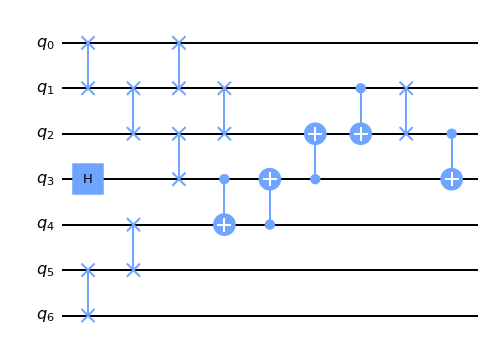

In [8]:
# Designamos el pase BasicSwap al mapa de acoplamiento
ls = LookaheadSwap(coupling_map=mapa)

#Definimos nuestro administrador de pases con el pase BasicSwap
admin = PassManager(ls)

# Aplicamos el administrador de pases al circuito
lookahead_qc = admin.run(qc)

# Visualizamos el nuevo circuito
lookahead_qc.draw(output = 'mpl')

Podemos notar que, al igual que con el cambio básico, solo se tienen compuertas sobre 2 qubits acoplados, con la diferencia que el número de compuertas totales utilizadas en mucho menor al ejemplo anterior. Además se puede notar que el tiempo de ejecución también fue menor al cambio simple.

Finalmente, podemos utilizar el pase `StochasticSwap`, el cual utiliza algoritmos aleatorios para implementar las compuertas *Swap*.

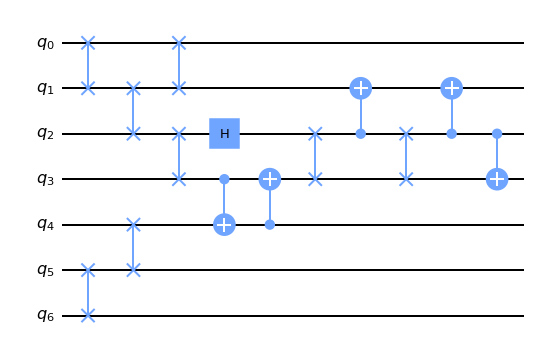

In [9]:
# Designamos el pase BasicSwap al mapa de acoplamiento
ss = StochasticSwap(coupling_map=mapa)

#Definimos nuestro administrador de pases con el pase BasicSwap
admin = PassManager(ss)

# Aplicamos el administrador de pases al circuito
estocástico_qc = admin.run(qc)

# Visualizamos el nuevo circuito
estocástico_qc.draw(output = 'mpl')

Podemos notar que la complejidad del circuito es muy parecida al ejemplo anterior. Sin embargo, si el circuito es más complejo, este pase puede tener un tiempo de compilación mas corto que los demás.

<a id="secc3"></a>
# Administradores de pase predeterminados

Ahora que hemos aprendido un poco de los pases que podemos utilizar para poder optimizar nuestro circuito, podemos conocer los administradores de pase predeterminados para obtener diferentes niveles de optimización por medio de una serie de pases. Para esto se ocupa la función `transpile()` donde el primer argumento corresponde al circuito que se quiere optimizar, el segundo al backend a utilizar para la optimización. 

El tercer argumento es el nivel de optimización que estamos buscando y este va de 0 a 3, los cuales están dados por:

* `optimization_level=0`: Solo mapea el circuito al backend sin una optimización explícita fuera del mapeo.
* `optimization_level=1`: Mapea el circuito además de una pequeña optimización para compuertas adyacentes.
* `optimization_level=2`: Optimización media, incluye un diseño que se adapta al ruido producido por el backend y cancelación de compuertas basado en la relación de conmutación de compuertas.
* `optimization_level=3`: Optimización de alto peso. Además de los pasos de los niveles anteriores, optimiza en bloques de compuertas de 2 qubits en el circuito.

Es importante notar que al aumentar el nivel de optimización, el tiempo de ejecución será mayor, por lo que se debe tomar en cuenta la complejidad del circuito para analizar el nivel de optimización necesario. El siguiente ejemplo muestra la diferencia en la complejidad del circuito dependiendo de cada nivel de optimización. 

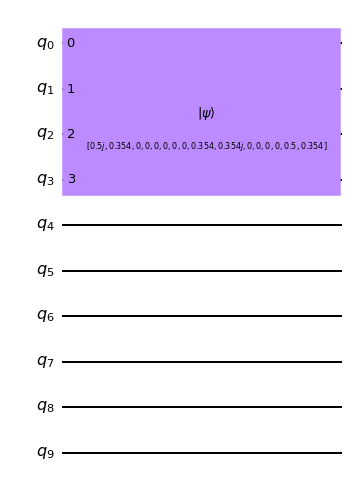

In [10]:
#Definimos el backend, en este caso simulamos la arquitectura de Tokyo, un dispositivo de 20 qubits de IBM
backend = FakeTokyo()

#Definimos un circuito de 10 qubits y lo inicializamos en un estado aleatorio
qc = QuantumCircuit(10)

estado_aleatorio = [
    1 / math.sqrt(4) * complex(0, 1),
    1 / math.sqrt(8) * complex(1, 0),
    0,
    0,
    0,
    0,
    0,
    0,
    1 / math.sqrt(8) * complex(1, 0),
    1 / math.sqrt(8) * complex(0, 1),
    0,
    0,
    0,
    0,
    1 / math.sqrt(4) * complex(1, 0),
    1 / math.sqrt(8) * complex(1, 0)]

qc.initialize(estado_aleatorio, range(4))
qc.draw(output='mpl')

In [11]:
# Realizamos la optimización de nivel 0
optimized_0 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=0)
print('Compuertas = ', optimized_0.count_ops())
print('Profundidad = ', optimized_0.depth())

Compuertas =  OrderedDict([('cx', 70), ('u3', 15), ('u1', 15), ('reset', 4)])
Profundidad =  73


In [12]:
# Realizamos la optimización de nivel 1
optimized_1 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=1)
print('Compuertas = ', optimized_1.count_ops())
print('Profundidad = ', optimized_1.depth())

Compuertas =  OrderedDict([('cx', 70), ('u3', 15), ('u1', 6)])
Profundidad =  64


In [13]:
# Realizamos la optimización de nivel 2
optimized_2 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=2)
print('Compuertas = ', optimized_2.count_ops())
print('Profundidad = ', optimized_2.depth())

Compuertas =  OrderedDict([('cx', 64), ('u3', 15), ('u1', 6)])
Profundidad =  60


In [14]:
# Realizamos la optimización de nivel 3
optimized_3 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=3)
print('Compuertas = ', optimized_3.count_ops())
print('Profundidad = ', optimized_3.depth())

Compuertas =  OrderedDict([('cx', 20), ('u3', 15), ('u1', 6)])
Profundidad =  38


Es importante notar que la función `transpile()` también puede ser utilizada para poder implementar un administrador de pasos personalizado como el que desarrollamos en la sección anterior, para esto se cambia el tercer argumento por el kwarg `pass_manager=` y este debe ser igual al `PassManager()` creado. Existen otra serie de argumentos que puede tomar esta función para detallar más la transformación, para esto puedes consultar el siguiente <a href="https://qiskit.org/documentation/stubs/qiskit.compiler.transpile.html">enlace</a>.

<a id="secc3.1"></a>
## Barrera

Sabemos que el nivel 1 de optimización optimiza las compuertas adyacentes. Por ejemplo, si se tienen 2 compuertas *X* adyacentes, estas provocan una rotación de $2\pi$ sobre el eje X, es decir, regresa al mismo estado, por lo que el transpilador las elimina como se muestra en el siguiente ejemplo:

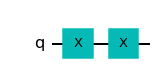

In [15]:
# Definimos el circuito de 1 qubit con 2 compuertas X
qc = QuantumCircuit(1)
qc.x(0)
qc.x(0)
qc.draw(output='mpl')

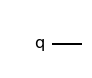

In [16]:
# Aplicamos el transpilador
backend = FakeArmonk()
xx = transpile(qc, backend=backend)
xx.draw(output='mpl')

Si no queremos que se eliminen esas compuertas podemos añadir una barrera utilizando el método `barrier()`, esta no solo es una herramienta visual para poder seccionar el circuito. También sirve como una división de las zonas en las que actúa el transpilador, es decir, si se colocan 2 compuertas *X* separadas por una barrera, el transpilador no las eliminará.

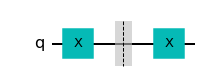

In [17]:
circ = QuantumCircuit(1)
circ.x(0)
circ.barrier(0)
circ.x(0)
circ.draw(output='mpl')

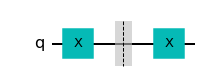

In [18]:
backend = FakeArmonk()
barrera = transpile(circ, backend=backend)
barrera.draw(output='mpl')

<a id="secc4"></a>
# Referencias

- [1] Qiskit Development Team. Qiskit Tutorials: Transpiler Passes and Pass Manager. Consultado en https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html

- [2] Qiskit Development Team. Documentation: Transpiler. Consultado en https://qiskit.org/documentation/apidoc/transpiler.html 

<table width="100%">
    <tr style="background-color:white;">
        <td>
            <div style="text-align: left;">
            <a href="01_circuitos_cuanticos.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                &lt;&lt; Notebook anterior: Circuitos cuánticos
            </a>
            </div>
        </td>
        <td>
            <div style="text-align: right;">
            <a href="03_qiskit_pulse.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                Notebook siguiente: Qiskit Pulse >>
            </a>
            </div>
        </td>
    </tr>
</table>